### Exact solution of RTA Boltzmann in Gubser Symmetry (arXiv: 1305.7234v2)
The RTA Boltzmann EQN:
$$p^{\mu}\partial_{\mu}f(x;p) = C[f(x;p)] = -\frac{u \cdot p}{\tau_R}(f - f_{eq})$$

Recall useful definitions of boost invariant variables:
$$\tau = \sqrt{t^2 - z_2}$$
$$w = tp^z - zE$$
$$v = Et - zp^z = \sqrt{w^2 + \tau^2(m^2 + p_T^2)}$$

At midrapidity $z=0$ these reduce to 
$$\tau = t$$
$$w = tp^z$$
$$v = Et$$

The invariant momentum integration measure
$$dP = 2 d^4p \delta(p^2-m^2)\Theta(p^0) = \frac{dw}{v}d^2p_T$$

Our Boltzmann EQN has the solution
$$f(\tau, w, p_T) = D(\tau, \tau_0)f_0(w, p_T) + \int_{\tau_0}^{\tau}\frac{d\tau'}{\tau_R(\tau')}D(\tau, \tau')f_{eq}(\tau', w, pT)$$

The Damping Function is defined by 
$$D(\tau_2, \tau_1) = exp\left[-\int_{\tau_1}^{\tau_2}\frac{d\tau''}{\tau_R(\tau'')}\right]$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import seaborn as sns
import dill
import time
sns.set()
%matplotlib inline

hbarc = 0.197 #GeV * fm

## First we want to read the solution for the Temperature from file

Michael Strickland's rta code solves the Boltzmann Eqn in RTA for the Bjorken symmetry...

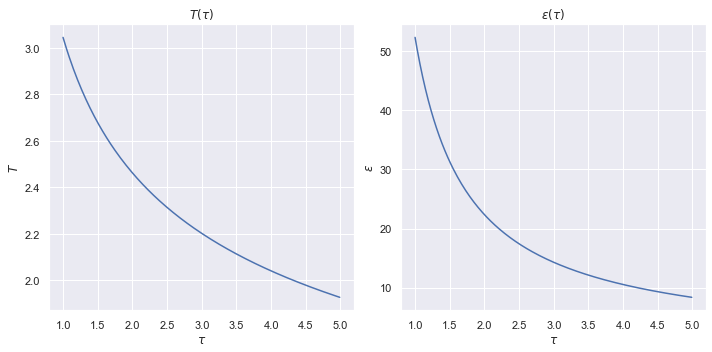

In [2]:
#read the output from Strickland's rta, which is the effective temperature as a function of tau
niters = 5
T0 = 0.6 # initial Temperature in GeV
T0_fm = T0 / hbarc #initial Temperature in fm^-1
T_profile = pd.read_csv('input/Teff.dat', sep='\t', header=None, names=['tau', 'T'])
#scale the file (which contains T/T0) by T0
T_profile['T'] = T_profile['T'] * T0 / hbarc #T profile in fm^-1
#add the energy density as a column
eos_fac = 6. / (np.pi**2) 
T_profile['e'] = eos_fac * T_profile['T']**4.
fix, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(T_profile['tau'], T_profile['T'])
axes[0].set_title(r'$T(\tau)$')
axes[0].set_xlabel(r'$\tau$')
axes[0].set_ylabel(r'$T$')
axes[1].plot(T_profile['tau'], T_profile['e'])
e0 = T_profile['e'].loc[0]
#axes[1].plot(T_profile['tau'], e0 / T_profile['tau'], label = r'$e_0 / \tau$' )
axes[1].set_title(r'$\epsilon(\tau)$')
axes[1].set_xlabel(r'$\tau$')
axes[1].set_ylabel(r'$\epsilon$')
#axes[1].legend()
plt.tight_layout()
plt.show()

## Momentum space transformations

In [3]:
def w_func(t, pz):
    #in general w = t*p^z - z*E, but we are only interested in midrapidity z=0
    return t*pz
def v_func(t, E):
    #in general v = E*t - z*p^z, but we are only interested in midrapidity z=0
    return t*E

## Generate Initial Conditions for Momentum Dependence for KT_ISO

NOTE : all momenta should be the covariant components.

In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad

#To find the initial momentum dependence of F() at tau_0, we need to 
#construct the solution from the Temperature profile
c = 100000.0 # 5 eta / s
tau0 = 1.0

#try a different interpolator that has built in integration routine 
T_interp = InterpolatedUnivariateSpline(T_profile['tau'], T_profile['T'], k=3)

def f_eq(tau, w, pT, T):
    p_eta = w #covariant 
    p_tau = np.sqrt(pT**2 + (p_eta / tau)**2)
    return np.exp(-p_tau / T)

def DampingFunction(t2, t1, c):
    result = T_interp.integral(t1, t2)
    return np.exp(-1.0 * result / c)

def solution_integrand(tau_prime, tau, w, pT, c):
    return DampingFunction(tau, tau_prime, c) * T_interp(tau_prime) * f_eq(tau_prime, w, pT, T_interp(tau_prime)) / c

def f_solution(tau, w, pT, c):
    I1 = DampingFunction(tau, tau0, c) * f_eq(tau0, w, pT, T0)
    I2, err = quad(solution_integrand, tau0, tau, args=(tau, w, pT, c))
    return I1 + I2

In [5]:
c0 = 100000.
tau_grid = T_profile['tau'][::10].values
vz_grid = np.linspace(0.0, 1.0, 100)
n_points_w = 200
n_points_pT = 200
n_points_p = 200

### Generate solution in $w$ and $p_T$

Works best if we use an adaptive grid in momenta where the magnitude is set by the Temperature scale. Probably should try using a variable transformation to a bounded integration domain!

In [20]:
time_b = time.time()
soln_milne = np.zeros( ( len(tau_grid), n_points_w, n_points_pT ) )
for itau, tau in enumerate(tau_grid):
    T_scale = T_interp(tau)
    #set the momentum integration grid according to the temperature
    w_grid = np.linspace(0., 10. * T_scale, n_points_w)
    pT_grid = np.linspace(0.0, 10. * T_scale, n_points_pT)
    for iw, w in enumerate(w_grid):
        for ipT, pT in enumerate(pT_grid):
            soln_milne[itau, iw, ipT] = f_solution(tau, w, pT, c0)
with open('distribution_function_solution_milne.dill', 'wb') as file:
    dill.dump(soln_milne, file)
time_a = time.time()
time_diff = time_a - time_b
print("Took " + str(time_diff) + "sec")

KeyboardInterrupt: 

In [7]:
#read the solution for milne momenta
with open('distribution_function_solution_milne.dill', 'rb') as file:
    soln_milne = dill.load(file)

In [8]:
#integrate f(tau; w, pT) over pT and w to find energy density
#dw = w_grid[1] - w_grid[0] #Riemann sum
#dpT = pT_grid[1] - pT_grid[0] #Riemann sum
e_reconstruct = np.zeros(len(tau_grid))
for itau, tau in enumerate(tau_grid):
    T_scale = T_interp(tau)
    #set the momentum integration grid according to the temperature
    #this choice for the w scale gives convergence at the level of ~2% accuracy
    #there is probably a better way to choose the integration quadrature
    w_grid = np.linspace(0., 10. * T_scale, n_points_w)
    dw = w_grid[1] - w_grid[0]
    pT_grid = np.linspace(0.0, 10. * T_scale, n_points_pT)
    dpT = pT_grid[1] - pT_grid[0]
    temp = 0.
    for iw, w in enumerate(w_grid):
        for ipT, pT in enumerate(pT_grid):
            #at z = 0, E = sqrt(w^2 + (tau * pT)^2) / tau
            E = np.sqrt(w**2 + (tau * pT)**2) / tau
            v = v_func(tau, E)
            temp += soln_milne[itau, iw, ipT] * v_func(tau, E) * pT / tau**2
    #multiply by 2pi for azimuthal integral
    #multiply by 2 for only integrating over w > 0
    e_reconstruct[itau] = temp * dw * dpT * 2 * np.pi / hbarc * 2.

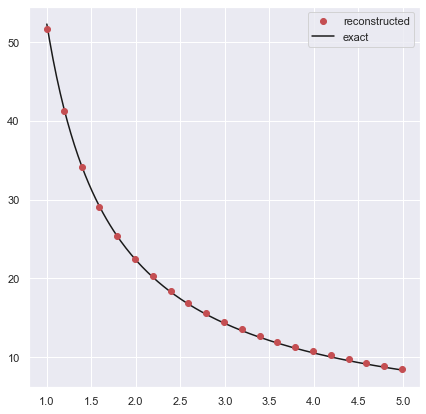

In [9]:
plt.figure(figsize=(7,7))
plt.plot(tau_grid, e_reconstruct, label='reconstructed', ls = 'None', marker='o', color='r', zorder=2)
plt.plot(T_profile['tau'], T_profile['e'], label='exact', color='k', zorder=1)
plt.legend()

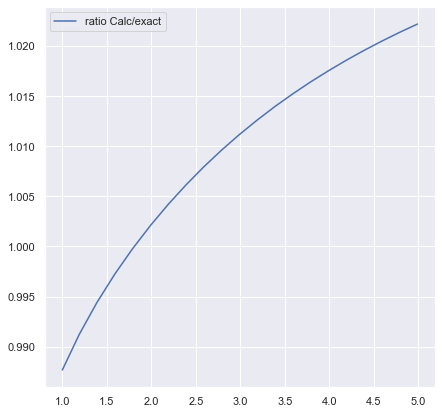

In [10]:
plt.figure(figsize=(7,7))
plt.plot(tau_grid, e_reconstruct / T_profile['e'][::10].values, label='ratio Calc/exact')
plt.legend()

### Generate solution in $v_z$ and $|p|$

In [11]:
time_b = time.time()
soln = np.zeros( ( len(tau_grid), len(vz_grid), n_points_p ) )
for itau, tau in enumerate(tau_grid):
    T_scale = T_interp(tau)
    #set the momentum integration grid according to the temperature
    p_grid = np.linspace(0., 10. * T_scale, 200)
    for ivz, vz in enumerate(vz_grid):
        for ip, p in enumerate(p_grid):
            pz = p * vz
            pT = np.sqrt(p**2 - pz**2)
            w = w_func(tau, pz)
            soln[itau, ivz, ip] = f_solution(tau, w, pT, c0)
with open('distribution_function_solution.dill', 'wb') as file:
    dill.dump(soln, file)
time_a = time.time()
time_diff = time_a - time_b
print("Took " + str(time_diff) + "sec")

Took 194.10714554786682sec


In [12]:
#read the soln from fill file
with open('distribution_function_solution.dill', 'rb') as file:
    soln = dill.load(file)

In [13]:
#f_soln_interp = RegularGridInterpolator(points = [tau_grid, vz_grid, p_grid], values=soln)

## Lets make some plots of the Distribution Function

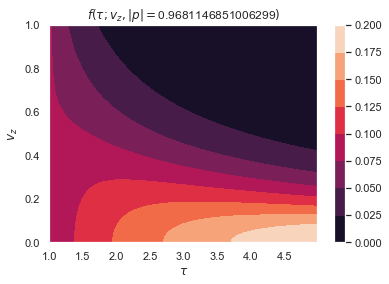

In [14]:
p_idx = 10
soln = np.array(soln)
xx, yy = np.meshgrid(tau_grid, vz_grid)
plt.contourf(xx, yy, soln[:,:,p_idx].T)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$v_z$")
plt.title(r"$f(\tau; v_z, |p| = $" + str(p_grid[p_idx])+ r"$)$")
cbar = plt.colorbar()
plt.show()

### Now, we can integrate over $|\boldsymbol{p}|$ to find $F(\tau; v_z)$

In [15]:
#riemann sum
F_soln = np.zeros( ( len(tau_grid), len(vz_grid) ) )
for itau, tau in enumerate(tau_grid):
    T_scale = T_interp(tau)
    #set the momentum integration grid according to the temperature
    p_grid = np.linspace(0., 10. * T_scale, 200)
    dp = p_grid[1] - p_grid[0]
    for ivz, vz in enumerate(vz_grid):
        temp = 0.
        for ip, p in enumerate(p_grid):
            temp += (p**3. * soln[itau, ivz, ip]) * (4. * np.pi)
        F_soln[itau, ivz] = temp * dp 

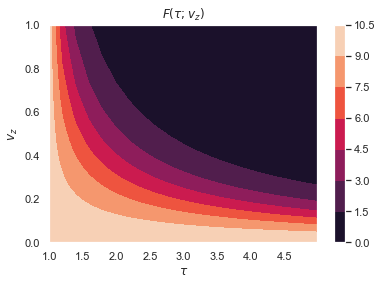

In [16]:
#plot F(tau, vz)
xx, yy = np.meshgrid(tau_grid, vz_grid)
plt.contourf(xx, yy, F_soln[:,:].T)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$v_z$")
plt.title(r"$F(\tau; v_z)$")
cbar = plt.colorbar()
plt.show()

### Now integrate over $v_z$ to find the energy density 

In [17]:
dvz = vz_grid[1] - vz_grid[0] #Riemann sum
e_reconstruct = np.zeros( ( len(tau_grid) ) )
for itau, tau in enumerate(tau_grid):
    temp = 0.
    for ivz, vz in enumerate(vz_grid):
        temp += F_soln[itau, ivz]
    e_reconstruct[itau] = temp * dvz * 2. 

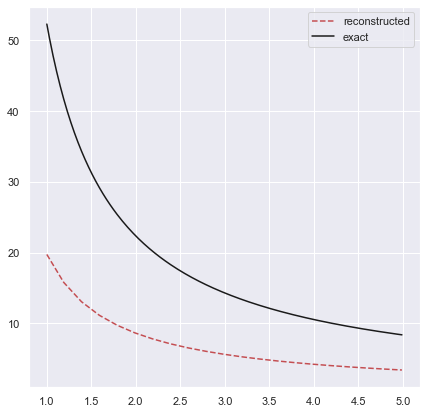

In [18]:
plt.figure(figsize=(7,7))
plt.plot(tau_grid, e_reconstruct, label='reconstructed', ls = '--', color='r')
plt.plot(T_profile['tau'], T_profile['e'], label='exact', color='k')
plt.legend()

In [19]:
# read the output from KTISo
dimx = 101
dx = 0.1
max_x = (dimx - 1) * dx / 2.0 
x_grid = np.linspace(-max_x, max_x, dimx)
fig = plt.figure(figsize=(8,5))
for tau, color in zip([0.525, 0.6, 0.8, 1.0], ['r', 'g', 'b', 'c', 'm']): 
    e_KT = np.loadtxt('KTIso/output/e_projection_'+ "{:.3f}".format(tau) +'.dat')
    #e_KT = np.loadtxt('KTIso/output_fs_gubser_check/initial_e_projection.dat')
    #take the slice at y = 0
    e_KT_profile = e_KT[:, (dimx-1)//2] 
    plt.plot(x_grid, e_KT_profile, label=r'$\tau=$'+str(tau), ls='-', color=color)
    
    #construct the analytic profile at y=0
    e_RTA = []
    for x in x_grid:
        r = np.sqrt(x**2)
        phi = np.arctan2(0.0, x)
        rho_val = rho_func(tau, r, q0)
        e_RTA.append( e_hat_interp(rho_val) / (tau**4) )
    plt.plot(x_grid, e_RTA, marker='o', color=color, markeredgecolor='black')
plt.legend()
plt.show()

OSError: KTIso/output/e_projection_0.525.dat not found.

<Figure size 576x360 with 0 Axes>